# Stochastic Weight Averaging - Gaussian (SWAG)

## Theoretic Foundation

SWAG was introduced in [A simple Baseline for Bayesian Uncertainty in Deep Learning (Maddox et al. 2019)](https://arxiv.org/abs/1902.02476).

## Imports

In [1]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import TwoMoonsDataModule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import DeterministicClassification, SWAGClassification
from lightning_uq_box.viz_utils import (
    plot_predictions_classification,
    plot_two_moons_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = TwoMoonsDataModule()

X_train, y_train, X_test, y_test, test_grid_points = (
    dm.X_train,
    dm.y_train,
    dm.X_test,
    dm.y_test,
    dm.test_grid_points,
)

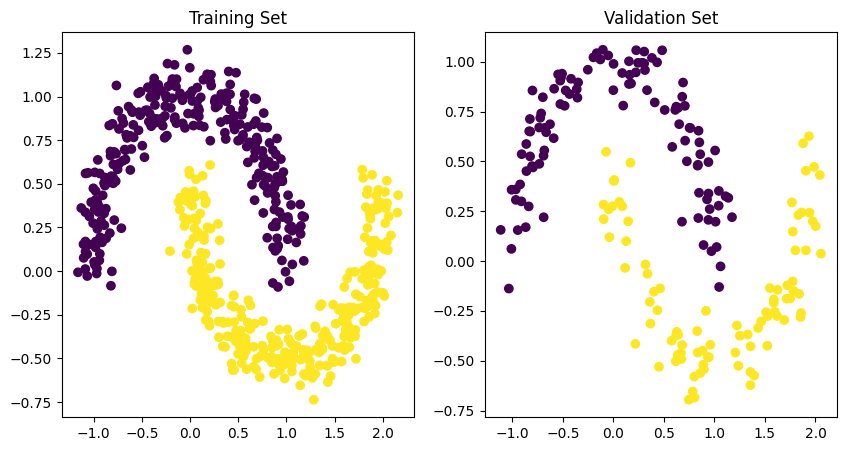

In [5]:
plot_two_moons_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Classification problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://torchgeo.readthedocs.io/en/stable/api/models.html#MLP). We define a model with two outputs corresponding to the two classes.

In [6]:
network = MLP(n_inputs=2, n_hidden=[50, 50, 50], n_outputs=2, activation_fn=nn.ReLU())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [8]:
deterministic_model = DeterministicClassification(
    network, loss_fn=nn.CrossEntropyLoss(), optimizer=partial(torch.optim.Adam, lr=1e-3)
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [9]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=50,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [10]:
trainer.fit(deterministic_model, dm)

Missing logger folder: /tmp/tmp9e6mfh_n/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.4 K 
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.021     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.

## Training Metrics

To get some insights into how the training went of our underlying deterministic model, we can use the utility function to plot the training loss and RMSE metric.

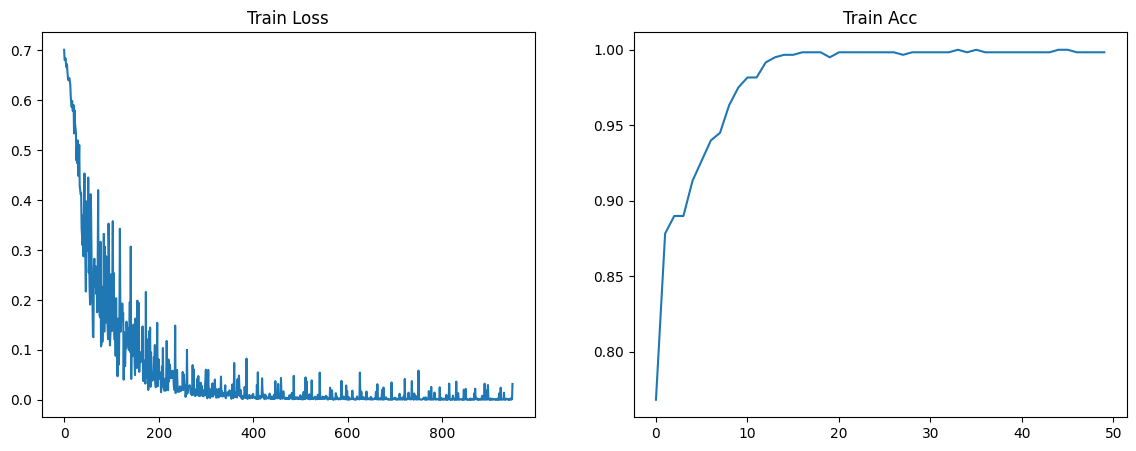

In [12]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), "Acc")

We can also make predictions with the underlying model.

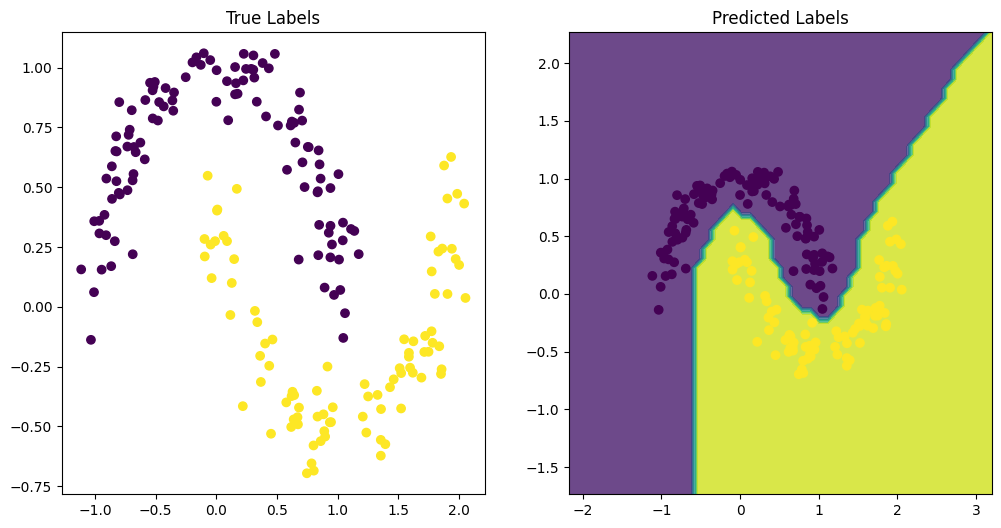

In [13]:
deterministic_preds = deterministic_model.predict_step(test_grid_points)
fig = plot_predictions_classification(
    X_test, y_test, deterministic_preds["pred"].argmax(-1), test_grid_points
)

## Apply SWAG

We now have a deterministic model that can make predictions, however, we do not have any uncertainty around the network weights. SWAG is a Bayesian Approximation method to capture this uncertainty, and we will now apply it to obtain epistemic uncertainty.

In [15]:
swag_model = SWAGClassification(
    deterministic_model.model,
    max_swag_snapshots=30,
    snapshot_freq=1,
    num_mc_samples=50,
    swag_lr=1e-3,
    loss_fn=nn.CrossEntropyLoss(),
)

## Prediction

For prediction we can either rely on the `trainer.test()` method or manually conduct a `predict_step()`. Using the trainer will save the predictions and some metrics to a CSV file, while the manual `predict_step()` with a single input tensor will generate a dictionary that holds the mean prediction as well as some other quantities of interest, for example the predicted standard deviation or quantile. The SWAG wrapper module will conduct the SWAG fitting procedure automatically before making the first prediction and will use it for any subsequent call to sample network weights for the desired number of Monte Carlo samples.

In [17]:
trainer = Trainer(enable_progress_bar=False, max_epochs=30)
trainer.fit(swag_model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.4 K 
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.021     Total estimated model params size (MB)


/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=30` reached.


In [18]:
preds = swag_model.predict_step(test_grid_points)

## Evaluate Predictions

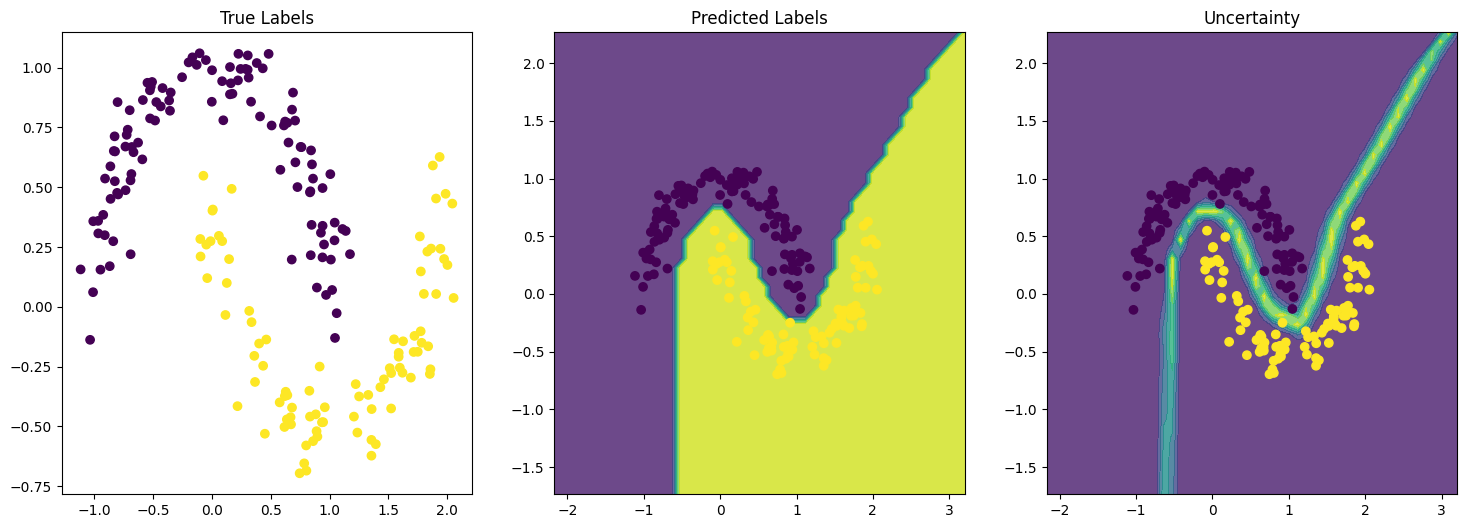

In [19]:
fig = plot_predictions_classification(
    X_test, y_test, preds["pred"].argmax(-1), test_grid_points, preds["pred_uct"]
)